In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

import os
import requests
import json
import regex as re

import lib_sean

pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
#  dir setting
root_dir = '\\'.join(os.getcwd().split('\\')[:-1])
data_dir = root_dir + '\\' + 'Data\\'

##### EDA - original set

In [4]:
df = pd.read_excel(data_dir + 'property_data.xlsx')
df_rev_geocoding = pd.read_excel(data_dir + 'rev_geocoding.xlsx')


In [5]:
df = lib_sean.clean_data(df, df_rev_geocoding)
df.rename(columns=lib_sean.col_renamer, inplace=True)
print(df.shape)


(102575, 23)


In [6]:
print(df.columns)
df.isna().sum().sort_values(ascending=False)[:10]


Index(['id', 'name', 'host_id', 'host_name', 'nyc_borough', 'neighborhood',
       'latitude', 'longitude', 'instant_bookable', 'cancellation_policy',
       'room_type', 'construction_year', 'price', 'service_fee',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'house_rules', 'coordinate', 'full_address',
       'zipcode', 'property_name'],
      dtype='object')


house_rules            52123
minimum_nights           408
host_name                406
zipcode                  312
cancellation_policy       74
nyc_borough               24
id                         0
service_fee                0
full_address               0
coordinate                 0
dtype: int64

In [7]:
df_by_neighbor = df.groupby(by=['neighborhood']).agg(
    avg_price=pd.NamedAgg(column='price', aggfunc='mean'),
    avg_monthy_review=pd.NamedAgg(column='reviews_per_month', aggfunc='mean')
)
df_by_neighbor


,avg_price,avg_monthy_review
neighborhood,,
Allerton,636.23,2.04
Arden Heights,804.89,1.65
Arrochar,625.75,1.33
Arverne,652.13,1.51
Astoria,639.00,1.31
...,...,...
Windsor Terrace,579.92,1.29
Woodhaven,630.49,2.03
Woodlawn,587.14,2.40


- appeared that there is no relationship between rental price and monthly review, probably owing to the unwillingness of customers to give review.
- As a result, the review data is sparse and therefore invalid for drawing statistical conclusions

count    224.00
mean     622.51
std       96.31
min      107.67
25%      593.00
50%      626.86
75%      652.32
max     1045.00
Name: avg_price, dtype: float64


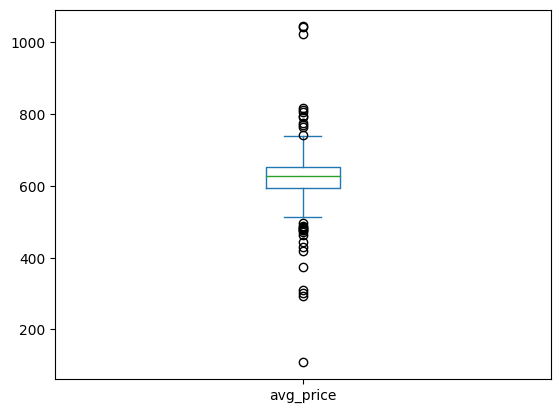

In [8]:
df_by_neighbor.avg_price.plot(kind='box')
print(df_by_neighbor.avg_price.describe())


- It can be concluded from the box plot that the rental price features low variance and is roughly of normal distribution. That way, average price could be a good index for pricing.

In [9]:
df_by_neighbor.avg_price.sort_values(ascending=False)[:10]


neighborhood
New Dorp                 1045.00
Chelsea, Staten Island   1042.00
Fort Wadsworth           1024.00
Little Neck               817.75
Jamaica Hills             812.90
Arden Heights             804.89
Midland Beach             796.18
Shore Acres               792.26
Mill Basin                775.14
Riverdale                 768.74
Name: avg_price, dtype: float64

In [10]:
# neighborhoods where working people dwell in -- according to GPT
df_by_neighbor.avg_price.sort_values(ascending=False)[
    ['Astoria', 'Washington Heights', 'Park Slope', 'Long Island City', 'Williamsburg']]


neighborhood
Astoria              639.00
Washington Heights   602.20
Park Slope           607.81
Long Island City     647.36
Williamsburg         625.54
Name: avg_price, dtype: float64

In [11]:
# export cleaned dataset
#df.to_csv(data_dir + 'property_data_cleaned.csv')


##### EDA - Inside Airbnb NYC Listings
- take a look at the relationship between monthly price and daily price

In [12]:
df_ia = pd.read_csv(data_dir + 'Obsolute/listings.csv')
df_ia.rename(columns=lib_sean.col_renamer, inplace=True)
df_ia.shape


C:\Users\Chaconne\AppData\Local\Temp\ipykernel_29136\610332070.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ia = pd.read_csv(data_dir + 'Obsolute/listings.csv')


(42931, 18)

In [13]:
df_ia.columns


Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'number_of_reviews_ltm', 'license'],
      dtype='object')

##### EDA - Geographical set
- tour site data
    - looks good
    - can perform geographical analysis and visualization using this dataset

In [14]:
df_tour_site = pd.read_excel(data_dir + 'New_York_Tourist_Locations.xlsx')


C:\Users\Chaconne\AppData\Roaming\Python\Python310\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [15]:
df_tour_site.head(5)


,Tourist_Spot,Address,Zipcode
0,47th Street - The Diamond District,"47th St. betw. Fifth & Sixth Aves. Manhattan, ...",10036
1,9/11 Memorial & Museum,World Trade Center (museum: 180 Greenwich St.)...,10007
2,Abyssinian Baptist Church,"132 Odell Clark Place New York, NY 10030, Harlem",10030
3,Alice Austen House Museum,"2 Hylan Blvd. Staten Island, NY 10305, Staten ...",10305
4,Alice Tully Hall,"1941 Broadway Manhattan, NY 10023, Upper West ...",10023


##### EDA - DOF Summary of Neighborhood Sales by Neighborhood Citywide by Borough
    - Records sales of homes
    - rows are kind of few
    - many rows are out dated (records from around 10 years ago)
    - most recent records were from 2021. The dataset appears obsolute

In [16]:
df_cny_sale = pd.read_csv(
    data_dir + 'DOF__Summary_of_Neighborhood_Sales_by_Neighborhood_Citywide_by_Borough.csv')


In [17]:
df_cny_sale.shape


(7180, 9)

In [18]:
df_cny_sale.columns


Index(['BOROUGH', 'NEIGHBORHOOD', 'TYPE OF HOME', 'NUMBER OF SALES',
       'LOWEST SALE PRICE', 'AVERAGE SALE PRICE', 'MEDIAN SALE PRICE',
       'HIGHEST SALE PRICE', 'YEAR'],
      dtype='object')

In [19]:
df_cny_sale.NEIGHBORHOOD.value_counts()[:5]


SUNNYSIDE                   67
BOERUM HILL                 36
CLINTON HILL                36
FLATBUSH-NORTH              36
FLATBUSH-LEFFERTS GARDEN    36
Name: NEIGHBORHOOD, dtype: int64

In [20]:
df_cny_sale.YEAR.value_counts()


2021    615
2013    611
2015    607
2014    605
2016    604
2018    602
2019    598
2017    594
2012    592
2010    587
2020    586
2011    579
Name: YEAR, dtype: int64

##### EDA - Dataset: nyc property assessment data
    - comprehensive and with sufficient rows.
    - some columns' meaning are not yet understood.

In [21]:
df_assess_2023 = pd.read_csv(
    data_dir + 'nyc_property_assessment_data_2023.csv').drop(columns='Unnamed: 0')


C:\Users\Chaconne\AppData\Local\Temp\ipykernel_29136\1063153676.py:1: DtypeWarning: Columns (1,5,6,9,10,23,34,67,71,74,75,76,88,93,100,101,105,109,111,133) have mixed types. Specify dtype option on import or set low_memory=False.
  df_assess_2023 = pd.read_csv(


In [22]:
df_assess_2023.shape


(1155828, 139)

In [23]:
df_assess_2023.columns


Index(['PARID', 'BORO', 'BLOCK', 'LOT', 'EASEMENT', 'SUBIDENT-REUC', 'RECTYPE',
       'YEAR', 'IDENT', 'SUBIDENT',
       ...
       'STORAGE_AREA_GROSS', 'GARAGE_AREA', 'OTHER_AREA_GROSS',
       'REUC_DESCRIPTION', 'EXTRACRDT', 'PYTAXFLAG', 'TENTAXFLAG',
       'CBNTAXFLAG', 'FINTAXFLAG', 'CURTAXFLAG'],
      dtype='object', length=139)

In [24]:
df_assess_2023.BLD_STORY.value_counts()


2.00      537526
3.00      147660
0.00      119508
1.00       89363
4.00       46244
           ...  
1.15           1
13.50          1
102.00         1
706.00         1
114.00         1
Name: BLD_STORY, Length: 136, dtype: int64

##### EDA - Borough-wise sales data from https://www.nyc.gov/site/finance/taxes/property-rolling-sales-data.page

In [25]:
df_bkl = pd.read_excel(data_dir + 'rollingsales_brooklyn.xlsx')
df_brn = pd.read_excel(data_dir + 'rollingsales_bronx.xlsx')
df_mht = pd.read_excel(data_dir + 'rollingsales_manhattan.xlsx')
df_qns = pd.read_excel(data_dir + 'rollingsales_queens.xlsx')
df_sti = pd.read_excel(data_dir + 'rollingsales_statenisland.xlsx')

df_list = [df_bkl, df_brn, df_mht, df_qns, df_sti]

df_rs = pd.concat(df_list)


In [26]:
df_rs.shape


(84391, 21)

In [27]:
# check if concat is performed correctly
col_same = True
comparer = df_list[0]
for i in range(1, 5):
    col_same = col_same and all(comparer.columns == df_list[i].columns)
col_same


True

In [28]:
df_rs.rename(columns=lib_sean.col_renamer, inplace=True)
df_rs.columns


Index(['borough', 'neighborhood', 'building_class_category',
       'tax_class_at_present', 'block', 'lot', 'easement',
       'building_class_at_present', 'address', 'apartment_number', 'zip_code',
       'residential_units', 'commercial_units', 'total_units',
       'land_square_feet', 'gross_square_feet', 'year_built',
       'tax_class_at_time_of_sale', 'building_class_at_time_of_sale',
       'sale_price', 'sale_date'],
      dtype='object')

- the data contains sales of differet building categories. 
- Should drop categories that are not for rental business. For example, warehouse and office buildings.
- Should enlarge the granularity of the factors, i.e., to merge levels that refer to similar building types.

In [29]:
df_rs.building_class_category.value_counts()


01 ONE FAMILY DWELLINGS                       17173
02 TWO FAMILY DWELLINGS                       14993
13 CONDOS - ELEVATOR APARTMENTS               14382
10 COOPS - ELEVATOR APARTMENTS                14265
03 THREE FAMILY DWELLINGS                      4226
07 RENTALS - WALKUP APARTMENTS                 3004
09 COOPS - WALKUP APARTMENTS                   2778
15 CONDOS - 2-10 UNIT RESIDENTIAL              1604
04 TAX CLASS 1 CONDOS                          1543
44 CONDO PARKING                               1489
17 CONDO COOPS                                 1331
12 CONDOS - WALKUP APARTMENTS                   979
05 TAX CLASS 1 VACANT LAND                      931
22 STORE BUILDINGS                              790
14 RENTALS - 4-10 UNIT                          640
08 RENTALS - ELEVATOR APARTMENTS                505
47 CONDO NON-BUSINESS STORAGE                   465
29 COMMERCIAL GARAGES                           463
43 CONDO OFFICE BUILDINGS                       340
11 SPECIAL C

In [30]:
def is_non_commercial_building_category(category: str) -> bool:
    """
    assert if the building category is non commercial
    """

    pat_commercial = r'LAND|WAREHOUSE|THEATRES|TRANSPORTATION|GOVERNMENTAL|STORE|FACTORIES|OFFICE|COMMERCIAL|PARKING|RELIGIOUS|ASYLUMS|FACILITIES'

    non_commercial = not re.search(pattern=pat_commercial, string=category)
    return non_commercial


filter_noncom_building_cate = filter(
    is_non_commercial_building_category, np.unique(df_rs.building_class_category.values))
# list that contains all the non commercial building categories
noncom_building_cate = list(filter_noncom_building_cate)
noncom_building_cate


['01 ONE FAMILY DWELLINGS',
 '02 TWO FAMILY DWELLINGS',
 '03 THREE FAMILY DWELLINGS',
 '04 TAX CLASS 1 CONDOS',
 '06 TAX CLASS 1 - OTHER',
 '07 RENTALS - WALKUP APARTMENTS',
 '08 RENTALS - ELEVATOR APARTMENTS',
 '09 COOPS - WALKUP APARTMENTS',
 '10 COOPS - ELEVATOR APARTMENTS',
 '11 SPECIAL CONDO BILLING LOTS',
 '12 CONDOS - WALKUP APARTMENTS',
 '13 CONDOS - ELEVATOR APARTMENTS',
 '14 RENTALS - 4-10 UNIT',
 '15 CONDOS - 2-10 UNIT RESIDENTIAL',
 '17 CONDO COOPS',
 '25 LUXURY HOTELS',
 '26 OTHER HOTELS',
 '41 TAX CLASS 4 - OTHER',
 '42 CONDO CULTURAL/MEDICAL/EDUCATIONAL/ETC',
 '45 CONDO HOTELS',
 '47 CONDO NON-BUSINESS STORAGE',
 '48 CONDO TERRACES/GARDENS/CABANAS']

In [31]:
# filter out records of commercial buildings
df_rs = df_rs.loc[df_rs.building_class_category.map(
    lambda v: v in noncom_building_cate), :]
df_rs.shape


(78674, 21)

In [32]:
def merge_building_category(bc: str) -> str:
    """
    merge building categories of similar interest into one
    """

    pat_dwell = r'DWELLINGS'
    pat_cond = r'CONDOS'
    pat_apt = r'APARTMENTS'

    is_dwell = re.search(pattern=pat_dwell, string=bc)
    if is_dwell:
        return pat_dwell

    is_cond = re.search(pattern=pat_cond, string=bc)
    if is_cond:
        return pat_cond

    is_apt = re.search(pattern=pat_apt, string=bc)
    if is_apt:
        return pat_apt

    return 'OTHER'


# merge building categories of similar features into one
df_rs.building_class_category = df_rs.building_class_category.map(
    merge_building_category)
df_rs.building_class_category.value_counts()


DWELLINGS     36392
APARTMENTS    20552
CONDOS        18508
OTHER          3222
Name: building_class_category, dtype: int64

- There are recoreds with zero sale price which should be dropped.
- has no clue of imputation

In [33]:
df_rs.sale_price.value_counts()[:5]


0         22135
10          728
650000      470
750000      450
800000      425
Name: sale_price, dtype: int64

In [34]:
df_rs = df_rs[df_rs.sale_price != 0]
print(df_rs.shape)
df_rs.sale_price.dtype


(56539, 21)


dtype('int64')

In [35]:
df_rs.groupby(by=['neighborhood', 'building_class_category']).agg(
    # column records the time frame of observed sales
    #time_range = pd.NamedAgg(column='sale_date', aggfunc= lambda col: (col.min(), col.max())),

    avg_sale_price=pd.NamedAgg(column='sale_price', aggfunc='mean'),
)

avg_sale_price
neighborhood       building_class_category                
AIRPORT LA GUARDIA CONDOS                        455000.00
                   DWELLINGS                     836398.33
ALPHABET CITY      APARTMENTS                   2873755.54
                   CONDOS                       1361257.00
                   DWELLINGS                    1133000.00
...                                                    ...
WOODSIDE           OTHER                        1491000.00
WYCKOFF HEIGHTS    APARTMENTS                   1062518.52
                   CONDOS                        762432.32
                   DWELLINGS                    1327256.78
                   OTHER                        1516286.17

[779 rows x 1 columns]

- export cleaned rolling sales dataset

In [36]:
#df_rs.to_csv(data_dir + 'nyc_rolling_sales_merged.csv', index=False)

##### EDA - condo rental income from https://data.cityofnewyork.us/City-Government/DOF-Cooperative-Comparable-Rental-Income-Citywide-/myei-c3fa
- this dataset provides info regarding the rental income of rental properties in NYC
- could be used for forecasting future rental income
- also note that NOI (net operating income) is the most commonly used metric for evaluating rental property profitability
- first of all, drop rows having no neighborhood values

In [37]:
df_rental_income = pd.read_csv(
    data_dir + 'DOF_Condominium_Comparable_Rental_Income_in_NYC.csv')
print(df_rental_income.shape)
df_rental_income.rename(columns=lib_sean.col_renamer, inplace=True)
df_rental_income.dropna(axis=0, subset='neighborhood', how='any', inplace=True)

(28507, 61)


In [38]:
print(df_rental_income.neighborhood.isna().sum())
df_rental_income.columns

0


Index(['boro_block_lot', 'condo_section', 'address', 'neighborhood',
       'building_classification', 'total_units', 'year_built', 'gross_sqft',
       'estimated_gross_income', 'gross_income_per_sqft', 'estimated_expense',
       'expense_per_sqft', 'net_operating_income', 'full_market_value',
       'market_value_per_sqft', 'boro_block_lot_1', 'address_1',
       'neighborhood_1', 'building_classification_1', 'total_units_1',
       'year_built_1', 'gross_sqft_1', 'estimated_gross_income_1',
       'gross_income_per_sqft_1', 'estimated_expense_1', 'expense_per_sqft_1',
       'net_operating_income_1', 'full_market_value_1',
       'market_value_per_sqft_1', 'distance_from_condo_in_miles',
       'boro_block_lot_2', 'address_2', 'neighborhood_2',
       'building_classification_2', 'total_units_2', 'year_built_2',
       'gross_sqft_2', 'estimated_gross_income_2', 'gross_income_per_sqft_2',
       'estimated_expense_2', 'expense_per_sqft_2', 'net_operating_income_2',
       'full_mar

In [39]:
df_rental_income.shape

(28505, 61)

- the original comparable condo dataset contains one target dataframe along with three referential dataframes
- we now have re-arranged the dataset so that all the three referential dataframes are also deemed as valid records. That way we have more rows for analysis

In [40]:
def compare_by_column(df: pd.DataFrame, col_name: str) -> pd.DataFrame:
    """
    select the target column of interest along with the other three comparable reference columns
    """
    list_col_names = [col_name]
    for i in range(1, 4):
        comparer_col_name = col_name + '_' + str(i)
        list_col_names.append(comparer_col_name)
    df_res = df[list_col_names]
    return df_res

<AxesSubplot:ylabel='Frequency'>

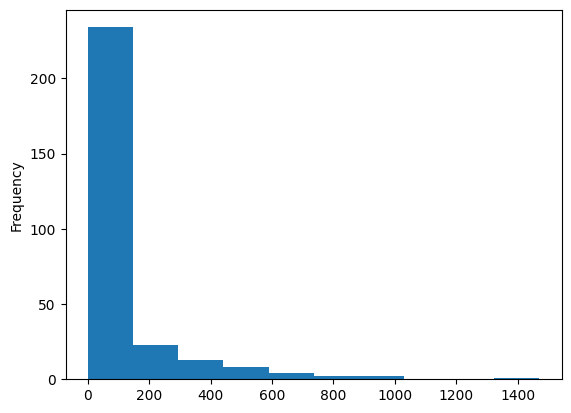

In [41]:
df_rental_income.neighborhood.value_counts().plot(kind='hist')

104.5
26.0
7.0
99.3205574912892


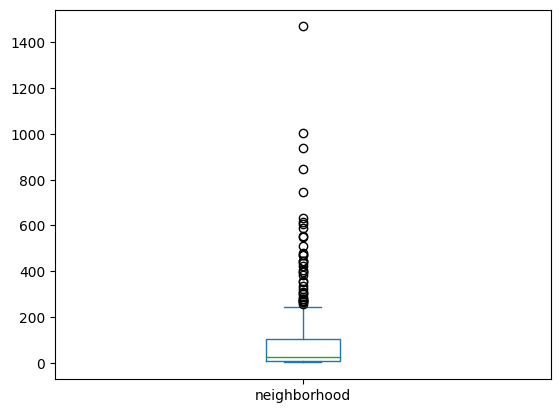

In [42]:
df_rental_income.neighborhood.value_counts().plot(kind='box')
print(df_rental_income.neighborhood.value_counts().quantile(q=0.75))
print(df_rental_income.neighborhood.value_counts().quantile(q=0.5))
print(df_rental_income.neighborhood.value_counts().quantile(q=0.25))
print(df_rental_income.neighborhood.value_counts().mean())

- histogram of neighborhood value counts is of Pareto distribution.
- median of the distribution is 26 while upper quartile is 104.5
- use 100 as cutoff to filter out those neighborhoods whose frequency in the dataset is too low
- should thus drop those with rare frequency as in later phase we will do many aggregation operations

In [43]:
neighbor_to_freq = dict(df_rental_income.neighborhood.value_counts())

df_condo_rearranged = df_rental_income.loc[
    df_rental_income.neighborhood.map(lambda n: neighbor_to_freq[n] >= 100), :
]
df_condo_rearranged.shape

(23668, 61)

- the profitability now is computed at unit level.
- this is because a property may contain multiple units, computation at property level may be biased for this multiplicity
- with the unit NOI we will then decide what are the neighborhoods with the highest unit NOI

In [44]:
df_rental_income.total_units.describe()

count   28505.00
mean       68.31
std       220.54
min         1.00
25%        15.00
50%        30.00
75%        71.00
max     20363.00
Name: total_units, dtype: float64

In [45]:
df_rental_income['unit_noi'] = df_rental_income.net_operating_income / df_rental_income.total_units
df_rental_income['sqft_noi'] = df_rental_income.net_operating_income / df_rental_income.gross_sqft

In [46]:
df_rental_income.report_year.value_counts().sort_index(ascending=False)[:5]

2021    3889
2020    2543
2019    2744
2018    2950
2017    2951
Name: report_year, dtype: int64

<AxesSubplot:title={'center':'Yearly Avg. Property NOI in Million'}, xlabel='report_year'>

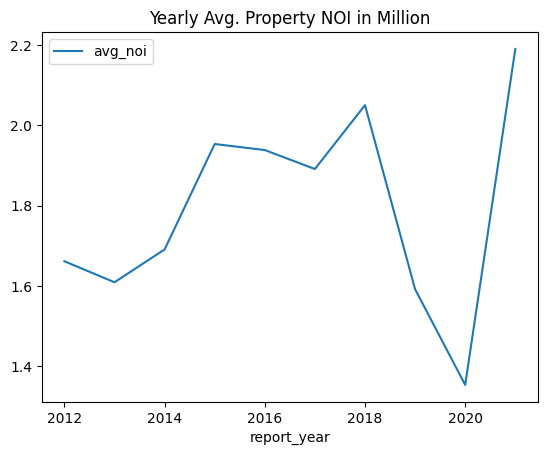

In [47]:
df_rental_income.groupby(by=['report_year']).agg(
    avg_noi=pd.NamedAgg(column='net_operating_income',
                        aggfunc=lambda c: c.mean() / 1000000),
).plot(
    kind='line', title='Yearly Avg. Property NOI in Million'
)


In [48]:
df_rental_income[df_rental_income.report_year.astype(int) >= 2018].groupby(by = ['neighborhood', 'report_year']).agg(
    avg_property_noi = pd.NamedAgg(column = 'net_operating_income', aggfunc = lambda c: c.mean() / 1000000),
)

avg_property_noi
neighborhood    report_year                  
15TH Q QUEENS   2019                     0.72
30TH Q BROOKLYN 2019                     0.81
50TH Q BROOKLYN 2019                     0.94
5TH Q BROOKLYN  2019                     0.36
75TH Q BROOKLYN 2019                     0.86
...                                       ...
WOODSIDE        2021                     0.61
WYCKOFF HEIGHTS 2018                     0.52
                2019                     0.49
                2020                     0.44
WYCKOFF HEIGHTS 2021                     0.55

[661 rows x 1 columns]

- can also plot the time series of avg_neighborhood_property_noi as a way to find out the neighborhoods with increasing NOI
- 2020 saw a slump in NOI as the covid was prevailing. 
- the data in 2021 could serve as an estimate of future NOI

<AxesSubplot:title={'center':'Yearly Avg. Unit NOI'}, xlabel='report_year'>

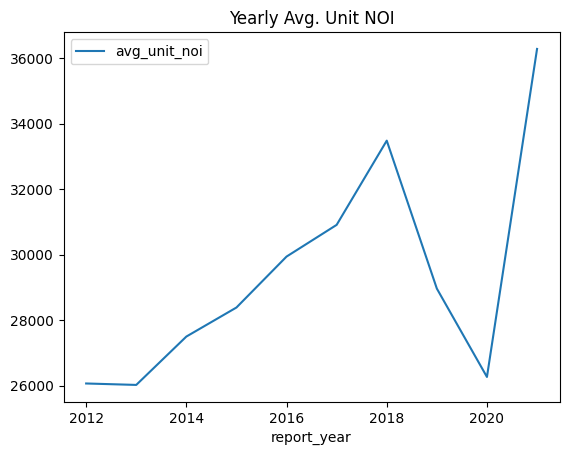

In [49]:
df_rental_income.groupby(by=['report_year']).agg(
    avg_unit_noi=pd.NamedAgg(column='unit_noi', aggfunc=lambda c: c.mean()),
).plot(kind='line', title='Yearly Avg. Unit NOI')


- can say that the yearly average of unit NOI is somewhere around 37000
- can also build a predictive model for forecasting

In [50]:
df_rental_income[df_rental_income.report_year == 2021].groupby(
    by=['neighborhood']
).agg(
    avg_unit_noi=pd.NamedAgg(column='unit_noi', aggfunc=lambda c: c.mean()),
    sample_count=pd.NamedAgg(column='unit_noi', aggfunc='count')
).sort_values(
    ascending=False, by='avg_unit_noi'
)[:10]


,avg_unit_noi,sample_count
neighborhood,,
EAST NEW YORK,443269.38,12
UPPER WEST SIDE (59-79),143658.80,77
CIVIC CENTER,97386.19,14
SOHO,94277.41,56
FLATIRON,84896.23,53
TRIBECA,72987.15,41
MIDTOWN CBD,71440.09,16
LITTLE ITALY,69628.83,17
CHELSEA,68379.66,101


In [51]:
df_rental_income[df_rental_income.report_year == 2021].groupby(
    by=['neighborhood']
).agg(
    avg_sqft_noi=pd.NamedAgg(column='sqft_noi', aggfunc=lambda c: c.mean()),
    sample_count=pd.NamedAgg(column='sqft_noi', aggfunc='count')
).sort_values(
    ascending=False, by='avg_sqft_noi'
)[:10]

,avg_sqft_noi,sample_count
neighborhood,,
FLATIRON,38.79,53
JAVITS CENTER,38.47,7
CHELSEA,38.46,101
MURRAY HILL,37.70,49
GREENWICH VILLAGE-WEST,37.44,56
SOHO,37.34,56
FASHION,36.94,21
MIDTOWN WEST,36.93,56
MIDTOWN CBD,36.51,16


In [52]:
# 2021 is the most recent year in this dataset
df_rental_income[df_rental_income.report_year == 2021].groupby(
    by=['neighborhood']
).agg(
    avg_sqft_gross_rev=pd.NamedAgg(column='gross_income_per_sqft', aggfunc=lambda c: c.mean()),
    sample_count=pd.NamedAgg(column='unit_noi', aggfunc='count')
).sort_values(
    ascending=False, by='avg_sqft_gross_rev'
)[:10]

,avg_sqft_gross_rev,sample_count
neighborhood,,
GREENWICH VILLAGE-WEST,54.69,56
FINANCIAL,54.16,11
TRIBECA,53.96,41
MIDTOWN WEST,53.84,56
MIDTOWN CBD,53.78,16
FLATIRON,53.20,53
CHELSEA,53.00,101
SOHO,52.54,56
MURRAY HILL,52.52,49


- another thing could be done here is to conduct geographical analysis using coordinate info
- to that end, map each address to its coordinate

In [55]:
unique_add = np.unique(df_rental_income.address.map(lambda add: add + ', New York, NY, USA'))
unique_add[:5]

array(['0 32 BROADWAY, New York, NY, USA',
       '1 BENNETT AVENUE, New York, NY, USA',
       '1 BOND STREET, New York, NY, USA',
       '1 CENTRAL PARK WEST, New York, NY, USA',
       '1 CENTRAL PARK, New York, NY, USA'], dtype=object)

In [58]:
coordiantes = lib_sean.get_coordinates(unique_add, api_key='')

KeyboardInterrupt: 

In [82]:
df_rental_income['coordiante'] = coordiantes

- for now, we will base on the above tables to select neighborhoods.
- should filter out those neighborhoods where there are limited house supply.
- so the next step is to estimate or to get the house inventory info in each neighborhood

##### EDA - Sentiment Analysis
- this is a dataset derived from the join of inside airbnb listings and inside airbnb reviews

In [52]:
df_sent = pd.read_csv(data_dir + 'reviews_sentiment_analysis.csv')
df_sent.rename(columns=lib_sean.col_renamer)
df_sent.listing_id = df_sent.listing_id.astype(int)
df_sent.id = df_sent.id.astype(int)
df_sent.shape


(530009, 7)

In [53]:
df_sent.head()


,listing_id,id,date,reviewer_id,sentiment_category,neighbourhood,avg_sentiment_category
0,15115382,581690116,12/25/2019,289984524,5,Woodside,4.02
1,15115382,591523348,1/11/2020,16177920,3,Woodside,4.02
2,15115382,595140562,1/19/2020,173362422,5,Woodside,4.02
3,15115382,595545885,1/20/2020,301401300,3,Woodside,4.02
4,15115382,597988500,1/26/2020,159226584,4,Woodside,4.02


In [54]:
df_sent.sentiment_category.describe()


count   530009.00
mean         3.98
std          0.67
min          1.00
25%          4.00
50%          4.00
75%          4.00
max          5.00
Name: sentiment_category, dtype: float64

In [55]:
df_ia_by_neighbor = df_ia.groupby(by=['neighbourhood']).agg(
    avg_lng=pd.NamedAgg(column='longitude', aggfunc='mean'),
    avg_lat=pd.NamedAgg(column='latitude', aggfunc='mean'),
)


dict_nb_to_coord = {
    i.strip(): (df_ia_by_neighbor.loc[i, 'avg_lng'], df_ia_by_neighbor.loc[i, 'avg_lat']) for i in df_ia_by_neighbor.index
}


In [56]:
def neighborhood_mapper(nb: str, is_latitude: bool) -> str:
    try:
        if is_latitude:
            res = dict_nb_to_coord[nb][1]
        else:
            res = dict_nb_to_coord[nb][0]
    except KeyError:
        return 'NA'


df_sent.neighbourhood = df_sent.neighbourhood.map(
    lambda n: n.strip().title()
)


df_sent['lng'] = df_sent.neighbourhood.map(
    lambda n: neighborhood_mapper(n, False)
)

df_sent['lat'] = df_sent.neighbourhood.map(
    lambda n: neighborhood_mapper(n, True)
)


In [57]:
df_sent[['lng', 'lat']]


,lng,lat
0,None,None
1,None,None
2,None,None
3,None,None
4,None,None
...,...,...
530004,NA,NA
530005,NA,NA
530006,NA,NA
530007,NA,NA


In [58]:
dict_nb_to_coord = {
    i.strip(): (df_ia_by_neighbor.loc[i, 'avg_lng'], df_ia_by_neighbor.loc[i, 'avg_lat']) for i in df_ia_by_neighbor.index
}
dict_nb_to_coord


{'Allerton': (-73.8595842801977, 40.86503104079037),
 'Arden Heights': (-74.17536142795709, 40.55273400017838),
 'Arrochar': (-74.07242357142857, 40.59289785714286),
 'Arverne': (-73.79516428987976, 40.59297607901072),
 'Astoria': (-73.92044800814838, 40.764738865549056),
 'Bath Beach': (-74.00690111730648, 40.60527295221553),
 'Battery Park City': (-74.01641676756134, 40.70987986027279),
 'Bay Ridge': (-74.02581526603724, 40.63100669731867),
 'Bay Terrace': (-73.780484, 40.784802),
 'Baychester': (-73.84180317247231, 40.872363613791784),
 'Bayside': (-73.76963329784122, 40.7622024531169),
 'Bayswater': (-73.76324158181818, 40.605753331818185),
 'Bedford-Stuyvesant': (-73.93823030967107, 40.68705907161248),
 'Belle Harbor': (-73.848011235488, 40.57762882839039),
 'Bellerose': (-73.72821460140318, 40.72986081059013),
 'Belmont': (-73.88689897999677, 40.85433216703582),
 'Bensonhurst': (-73.9943253763846, 40.61236823944558),
 'Bergen Beach': (-73.91056710246905, 40.62512497511937),
 'Boe

In [59]:
df_sent.neighbourhood.value_counts()


Brooklyn                             335272
Queens                               121928
Bronx                                 19391
Staten Island                         11111
The Bronx                              9684
                                      ...  
Bushwick                                  2
Pomona, California, United States         2
Brooklyn Heights                          1
Sunnyside, Queens                         1
Little Neck                               1
Name: neighbourhood, Length: 110, dtype: int64

##### EDA - RedFin Housing market data (full) from https://www.redfin.com/news/data-center/

In [60]:
df_redfin = pd.read_csv(data_dir + 'city_market_tracker.tsv000', sep='\t')
df_redfin.rename(columns=lib_sean.col_renamer, inplace=True)
print(df_redfin.shape)
df_redfin.columns


(4718104, 58)


Index(['period_begin', 'period_end', 'period_duration', 'region_type',
       'region_type_id', 'table_id', 'is_seasonally_adjusted', 'region',
       'city', 'state', 'state_code', 'property_type', 'property_type_id',
       'median_sale_price', 'median_sale_price_mom', 'median_sale_price_yoy',
       'median_list_price', 'median_list_price_mom', 'median_list_price_yoy',
       'median_ppsf', 'median_ppsf_mom', 'median_ppsf_yoy', 'median_list_ppsf',
       'median_list_ppsf_mom', 'median_list_ppsf_yoy', 'homes_sold',
       'homes_sold_mom', 'homes_sold_yoy', 'pending_sales',
       'pending_sales_mom', 'pending_sales_yoy', 'new_listings',
       'new_listings_mom', 'new_listings_yoy', 'inventory', 'inventory_mom',
       'inventory_yoy', 'months_of_supply', 'months_of_supply_mom',
       'months_of_supply_yoy', 'median_dom', 'median_dom_mom',
       'median_dom_yoy', 'avg_sale_to_list', 'avg_sale_to_list_mom',
       'avg_sale_to_list_yoy', 'sold_above_list', 'sold_above_list_mom',
 

- drop some monotonously valued columns first

In [61]:
df_redfin.region_type.value_counts()


place    4718104
Name: region_type, dtype: int64

In [62]:
df_redfin.region_type_id.value_counts()


6    4718104
Name: region_type_id, dtype: int64

In [63]:
df_redfin.drop(
    columns=['region_type', 'region_type_id', 'region'], inplace=True)


In [64]:
'New York' in df_redfin.city.value_counts().index


True

In [65]:
df_redfin_ny = df_redfin[df_redfin.city == 'New York']
df_redfin_ny.shape


(475, 55)

In [66]:
# export cleande redfin data
# df_redfin_ny.to_csv(data_dir + 'redfin_nyc_house_market_data.csv', index=False)

##### EDA - Redfin NYC House Market data -- derived from https://www.redfin.com/news/data-center/
- this one's cleaned from the previous full Redfin dataset. It contains only NYC records.

In [67]:
df_redfin_ny = pd.read_csv(data_dir + 'redfin_nyc_house_market_data.csv')
print(df_redfin_ny.shape)
df_redfin_ny.columns


(475, 55)


Index(['period_begin', 'period_end', 'period_duration', 'table_id',
       'is_seasonally_adjusted', 'city', 'state', 'state_code',
       'property_type', 'property_type_id', 'median_sale_price',
       'median_sale_price_mom', 'median_sale_price_yoy', 'median_list_price',
       'median_list_price_mom', 'median_list_price_yoy', 'median_ppsf',
       'median_ppsf_mom', 'median_ppsf_yoy', 'median_list_ppsf',
       'median_list_ppsf_mom', 'median_list_ppsf_yoy', 'homes_sold',
       'homes_sold_mom', 'homes_sold_yoy', 'pending_sales',
       'pending_sales_mom', 'pending_sales_yoy', 'new_listings',
       'new_listings_mom', 'new_listings_yoy', 'inventory', 'inventory_mom',
       'inventory_yoy', 'months_of_supply', 'months_of_supply_mom',
       'months_of_supply_yoy', 'median_dom', 'median_dom_mom',
       'median_dom_yoy', 'avg_sale_to_list', 'avg_sale_to_list_mom',
       'avg_sale_to_list_yoy', 'sold_above_list', 'sold_above_list_mom',
       'sold_above_list_yoy', 'price_drops',

In [68]:
print(df_redfin_ny[['period_begin', 'period_end']].min())
print(df_redfin_ny[['period_begin', 'period_end']].max())


period_begin    2015-05-01
period_end      2015-05-31
dtype: object
period_begin    2023-03-01
period_end      2023-03-31
dtype: object


In [69]:
df_redfin_ny[['period_begin', 'period_end']].dtypes


period_begin    object
period_end      object
dtype: object

In [70]:
df_redfin_ny_inventory = df_redfin_ny .loc[:, 'new_listings': 'months_of_supply_yoy']
print(df_redfin_ny_inventory.shape)
df_redfin_ny_inventory.head()

(475, 9)


,new_listings,new_listings_mom,new_listings_yoy,inventory,inventory_mom,inventory_yoy,months_of_supply,months_of_supply_mom,months_of_supply_yoy
0,297.00,-0.03,0.49,746.00,0.06,0.45,4.50,-0.40,-0.30
1,3837.00,-0.09,NaN,20483.00,-0.00,NaN,7.70,0.20,NaN
2,848.00,-0.28,0.03,3796.00,-0.05,-0.06,4.80,0.30,-1.20
3,3623.00,-0.12,-0.08,22341.00,-0.05,0.00,7.50,-0.70,0.70
4,4968.00,0.38,-0.24,15153.00,0.01,-0.05,6.50,-1.40,2.40


In [84]:
# new listings - available units in the market

df_redfin_ny.property_type.value_counts()

Townhouse                    95
All Residential              95
Single Family Residential    95
Condo/Co-op                  95
Multi-Family (2-4 Unit)      95
Name: property_type, dtype: int64